## Практическое задание

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [1]:
#!pip install tensorflow
#!pip install keras

In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pandas as pd

In [3]:
seed_value= 0
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
(train_imagesf,train_labelsf),(test_imagesf,test_labelsf)=fashion_mnist.load_data()

In [5]:
train_labelsf[0]

9

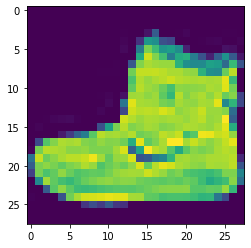

In [6]:
plt.imshow(train_imagesf[0])

In [7]:
# Normalize the images.
train_imagesf = (train_imagesf / 127) - 1
test_imagesf = (test_imagesf / 127) - 1

# Flatten the images.
train_images = train_imagesf.reshape((-1, 784))
test_images = test_imagesf.reshape((-1, 784))

print(train_images.shape) # (60000, 784)
print(test_images.shape)  # (10000, 784)

(60000, 784)
(10000, 784)


In [8]:
def architecture_test(train_images, train_labels, test_images, test_labels,
                      n_neurons, n_layers, n_epochs=15, activation='relu', optimizer='adam'):
    model = Sequential(name='my_model')
    model.add(Dense(n_neurons, activation='relu', input_shape=(784,)))  
    for _ in range(n_layers):
        model.add(Dense(n_neurons, activation=activation)) 
    model.add(Dense(10, activation='softmax')) 
    model.compile(
      optimizer=optimizer,
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'],
    ) 
    history_0_train = model.evaluate(train_images[:48000,:], to_categorical(train_labels[:48000]),verbose = 0)
    history_0_val = model.evaluate(train_images[48000:,:], to_categorical(train_labels[48000:]),verbose = 0)
    history = model.fit(
        train_images,
        to_categorical(train_labels),
        epochs=n_epochs,
        batch_size=64, validation_split=0.2, verbose = 0
    )
    test_result = model.evaluate(test_images, to_categorical(test_labels),verbose = 0)
    return {
        'model': model,
        'train_history': np.log([history_0_train[0]] + history.history['loss']), 
        'val_history': np.log([history_0_val[0]] + history.history['val_loss']),
        'history': history,
        'test_accuracy': test_result[1],
    }

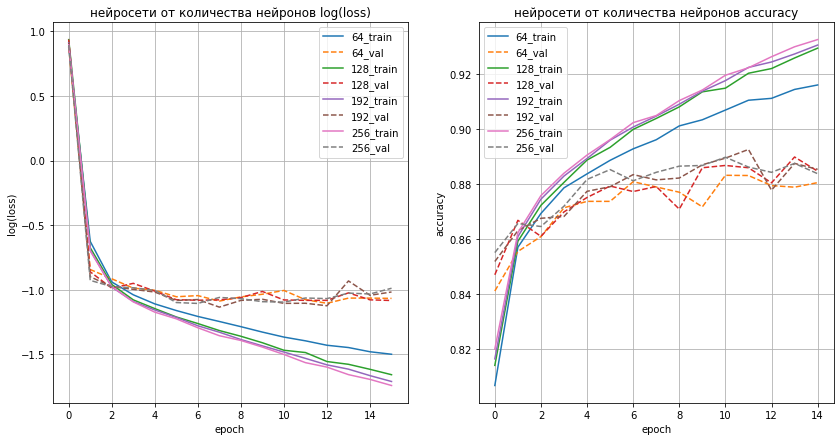

In [9]:
accuracy_n_neurons = []

epochs = 15
epoch = np.arange(epochs+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
for n_neurons in [64, 128, 192, 256]:
    result = architecture_test(train_images, train_labelsf, test_images, test_labelsf, 
                               n_neurons=n_neurons, n_layers=2, n_epochs=epochs)
    
    ax1.plot(epoch,result['train_history'],'-',label = f'{n_neurons}_train')
    ax1.plot(epoch,result['val_history'],'--',label = f'{n_neurons}_val')
    
    ax2.plot(np.arange(epochs),result['history'].history['accuracy'],'-',label = f'{n_neurons}_train')
    ax2.plot(np.arange(epochs),result['history'].history['val_accuracy'],'--',label = f'{n_neurons}_val')
    
    accuracy_n_neurons.append(
        {'n_neurons': n_neurons,
         'accuracy_': result['history'].history['accuracy'][-1], 
         'val_accuracy': result['history'].history['val_accuracy'][-1],
         'test_accuracy': result['test_accuracy']
        })
ax1.legend()
ax1.grid('On')
ax1.set_title('нейросети от количества нейронов log(loss)')
ax1.set_xlabel('epoch')
ax1.set_ylabel('log(loss)')

ax2.legend()
ax2.grid('On')
ax2.set_title('нейросети от количества нейронов accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
plt.show()

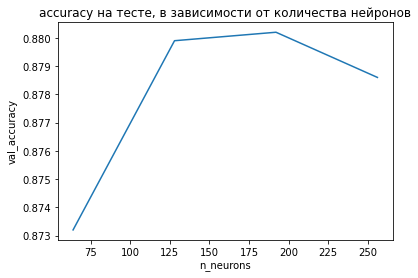

In [10]:
plt.plot([res['n_neurons'] for res in accuracy_n_neurons], [res['test_accuracy'] for res in accuracy_n_neurons])
plt.title('accuracy на тесте, в зависимости от количества нейронов')
plt.xlabel('n_neurons')
plt.ylabel('val_accuracy')
plt.show()

Оптимальное количество 128 нейронов, примем 128 нейронов в слое для последующего эксперимента

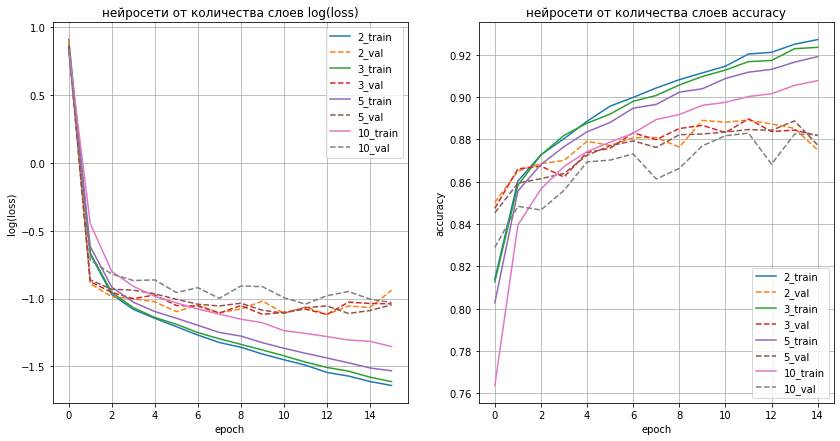

In [11]:
accuracy_n_layers = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
for n_layers in [2, 3, 5, 10]:
    result = architecture_test(train_images, train_labelsf, test_images, test_labelsf, 
                               n_neurons=128, n_layers=n_layers, n_epochs=epochs)
    
    ax1.plot(epoch,result['train_history'],'-',label = f'{n_layers}_train')
    ax1.plot(epoch,result['val_history'],'--',label = f'{n_layers}_val')
    
    ax2.plot(np.arange(epochs),result['history'].history['accuracy'],'-',label = f'{n_layers}_train')
    ax2.plot(np.arange(epochs),result['history'].history['val_accuracy'],'--',label = f'{n_layers}_val')
    accuracy_n_layers.append(
        {'n_layers': n_layers,
         'accuracy_': result['history'].history['accuracy'][-1], 
         'val_accuracy': result['history'].history['val_accuracy'][-1],
         'test_accuracy': result['test_accuracy'],
         'model': result['model']
        })
    
ax1.legend()
ax1.grid('On')
ax1.set_title('нейросети от количества слоев log(loss)')
ax1.set_xlabel('epoch')
ax1.set_ylabel('log(loss)')

ax2.legend()
ax2.grid('On')
ax2.set_title('нейросети от количества слоев accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
plt.show()

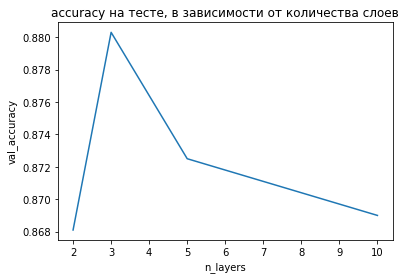

In [12]:
plt.plot([res['n_layers'] for res in accuracy_n_layers], [res['test_accuracy'] for res in accuracy_n_layers])
plt.title('accuracy на тесте, в зависимости от количества слоев')
plt.xlabel('n_layers')
plt.ylabel('val_accuracy')
plt.show()

Оптимальное число слоев: 3, сохраним веса для данной модели

In [13]:
best_model = [res['model'] for res in accuracy_n_layers if res['n_layers'] == 3][0]

In [14]:
best_model.save_weights('model.h5')

In [15]:
def optimizer_test(load_weights=True):
    optim_accuracy_results = []

    n_neurons = 128
    n_layers = 3
    for i_optim in ['SGD','RMSProp','adam','NAdam']:
        model = Sequential()
        model.add(Dense(n_neurons, activation='relu', input_shape=(784,)))  
        for _ in range(n_layers):
            model.add(Dense(n_neurons, activation='relu')) 
        model.add(Dense(10, activation='softmax'))
        if load_weights:
            model.load_weights('model.h5')
        model.compile(
            optimizer=i_optim,
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )
        hh0_tr = model.evaluate(train_images[:48000,:], to_categorical(train_labelsf[:48000]),verbose = 0)
        hh0_val = model.evaluate(train_images[48000:,:], to_categorical(train_labelsf[48000:]),verbose = 0) 
        hh = model.fit(
            train_images,
            to_categorical(train_labelsf),
            epochs=epochs,
            batch_size=32, validation_split=0.2, verbose = 0
        )
        train_acc = model.evaluate(train_images, to_categorical(train_labelsf),verbose = 0)[1]
        test_acc = model.evaluate(test_images, to_categorical(test_labelsf),verbose = 0)[1]
        optim_accuracy_results.append({
            'optim': i_optim,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })


        plt.plot(epoch,np.log([hh0_tr[0]]+hh.history['loss']),'-',label = model.optimizer.get_config()['name']+' train')
        plt.plot(epoch,np.log([hh0_val[0]]+hh.history['val_loss']),'--',label = model.optimizer.get_config()['name']+' val')
    plt.legend()
    plt.grid('On')

    plt.title('нейросети от оптимизатора log(loss)')
    plt.xlabel('epoch')
    plt.ylabel('log(loss)')
    plt.show()
    return optim_accuracy_results

Дообучим модель с различными оптимизаторами, используя ранее обученную модель

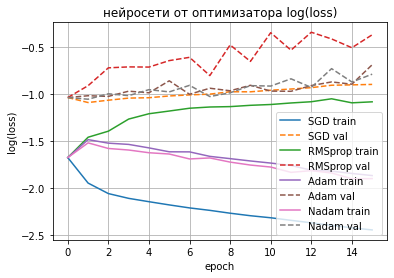

,optim,train_acc,test_acc
0,SGD,0.955817,0.8912
1,RMSProp,0.887233,0.8541
2,adam,0.927600,0.8737
3,NAdam,0.926683,0.8753


In [19]:
results = optimizer_test(load_weights=True)
pd.DataFrame(results)

Обучим модель с различными оптимизаторами, с нуля

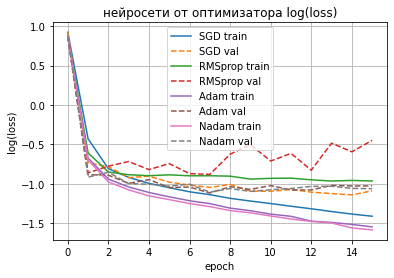

,optim,train_acc,test_acc
0,SGD,0.902717,0.8739
1,RMSProp,0.884650,0.8577
2,adam,0.919350,0.8821
3,NAdam,0.922683,0.8806


In [20]:
results = optimizer_test(load_weights=False)
pd.DataFrame(results)

Лучшая метрика accuracy при обучении с нуля получается с применением оптимизатора adam. Самая большая метрика на тесте получается с дообучением модели с обычным градиентным спуском, при этом данная модель максимально переобучена

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))  
for _ in range(3):
    model.add(Dense(128, activation='relu')) 
model.add(Dense(10, activation='softmax'))
model.load_weights('model.h5')
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

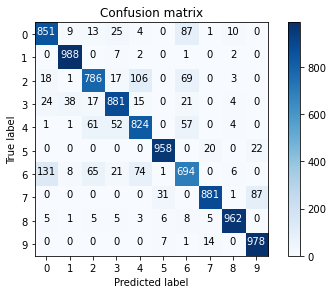

In [57]:
preds = np.argmax(model.predict(test_images), axis=1)
cnf_matrix = confusion_matrix(test_labelsf, preds)
plot_confusion_matrix(cnf_matrix, classes=np.arange(10),
                      title='Confusion matrix')
plt.show()

In [60]:
print(classification_report(test_labelsf, preds))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.94      0.99      0.97      1000
           2       0.83      0.79      0.81      1000
           3       0.87      0.88      0.88      1000
           4       0.80      0.82      0.81      1000
           5       0.96      0.96      0.96      1000
           6       0.74      0.69      0.72      1000
           7       0.96      0.88      0.92      1000
           8       0.97      0.96      0.97      1000
           9       0.90      0.98      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



<div>
<img src="./class_names.jpeg" align = "left" width="400"/>
</div>

* Наибольшее количество ошибок при классификации между футболкой и рубашкой, 
* Также довольно много ошибок типа: плащ-свитер, рубашка-свитер
* В целом данные типы ошибок довольно ожидаемы, что говорит об относитльно хорошем качестве классификации